In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

## Problem A

In [37]:
SWEEPS = 8000
H = 1
OMEGA = 1
M = 1
TAU = 5000
DELTATAU = 1
NTAU = int(TAU/DELTATAU)
HITSIZE = 0.1
ALPHA = 0.4

XLOW = -4
XHIGH = 4
NXBINS = 100
DELTAX = (XHIGH - XLOW) / NXBINS
HITSIZE = 0.1
x_bins = np.linspace(XLOW, XHIGH, NXBINS + 1)
prob_histogram = np.zeros(NXBINS)
x_path = np.zeros(NTAU)

In [38]:
def V(x):
    return ALPHA*x**4 - 2*x**2 + 1/ALPHA

In [39]:
def vary_path(x_current):
    x_prime = x_current + np.random.random() * 2 * HITSIZE - HITSIZE
    while x_prime > XHIGH or x_prime < XLOW:
        x_prime = x_current + np.random.random() * 2 * HITSIZE - HITSIZE
    return x_prime

def action(x_left, x_right):
    K = 0.5 * M * (((x_right - x_left))**2) / DELTATAU
    V = DELTATAU * ( ALPHA * ((x_left + x_right)/2)**4 - 2*((x_left + x_right)/2)**2 + 1/ALPHA)
    return K + V

def total_action(x_path):
    path_action = 0
    for i in range(-1, NXBINS-1):
        path_action += action(x_path[i], x_path[i+1])
    return path_action

def delta_action(x_path, x_prime, i):
    x_left = x_path[i-1]
    x_right = x_path[i+1] if i < NTAU-1 else x_path[0] #PBC.
    daction = action(x_left, x_prime) + action(x_prime, x_right) 
    daction -= action(x_left, x_path[i]) + action(x_path[i], x_right) #compute the resulting change from u in delta S.
    return daction

def MCMC(x_path, prob_histogram):
    num_accept = 0
    E_values = []
    for i in range(NTAU):
        x_prime = vary_path(x_path[i])
        daction = delta_action(x_path, x_prime, i)
        if daction <= 0:            
            x_path[i] = x_prime
        else:        
            prob = np.exp(-daction)
            if np.random.random() < prob:
                x_path[i] = x_prime
                num_accept += 1
    hist, _ = np.histogram(x_path, bins=x_bins)
    return hist

In [40]:
def x2_exp(pdf, x):
    return sum(pdf * x**2 * DELTAX)

def x4_exp(pdf, x):
    return sum(pdf * x**4 * DELTAX)

def E_exp(pdf, x2, x4):
    return x2 + 3*(ALPHA)*x4

x_centers = (x_bins[:-1] + x_bins[1:]) / 2
x2_sweeps = []
x4_sweeps = []
E_sweeps = []

BURNIN = 2500

for k in tqdm.tqdm(range(SWEEPS)):
    hist = MCMC(x_path, prob_histogram)
    if k >= BURNIN:
        prob_histogram += hist
    pdf = hist/np.sum(hist*DELTAX)
    x2 = x2_exp(pdf, x_centers)
    x4 = x4_exp(pdf, x_centers)
    x2_sweeps.append(x2)
    x4_sweeps.append(x4) 
    E_sweeps.append(E_exp(pdf, x2, x4))

100%|██████████| 8000/8000 [05:36<00:00, 23.76it/s]


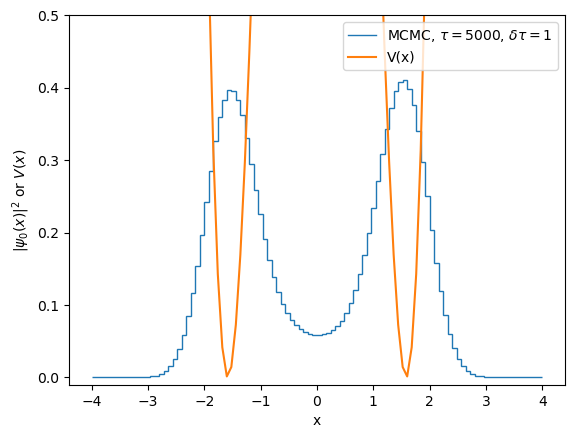

In [41]:
V_plot = V(x_bins)

plt.figure()
plt.stairs(prob_histogram/np.sum(prob_histogram*DELTAX), x_bins, label=f"MCMC, $\\tau = {TAU}$, $\\delta\\tau={DELTATAU}$")
plt.plot(x_bins, V(x_bins), label="V(x)")
plt.xlabel("x")
plt.ylabel("$|\psi_0(x)|^2$ or $V(x)$")
plt.ylim([-0.01, 0.5])
plt.legend()
plt.savefig("plots/sweeps_8000_tau_5000_dtau_1.png")
plt.show()

In [42]:
# Normalize the accumulated histogram to get the final probability density function
final_pdf = prob_histogram / np.sum(prob_histogram * DELTAX)

# Compute final ground state energy
x2_final = x2_exp(final_pdf, x_centers) #expectation of x**2
x4_final = x4_exp(final_pdf, x_centers) # expectation of x**4
E_0 = E_exp(pdf, x2, x4) # expectation of ground state energy

print("Ground State Energy:", E_0)

Ground State Energy: 10.910671930163204


In [43]:
E_avg = np.mean(E_sweeps[BURNIN:])
E_std = np.std(E_sweeps[BURNIN:])
print(E_avg)

10.648947596417436


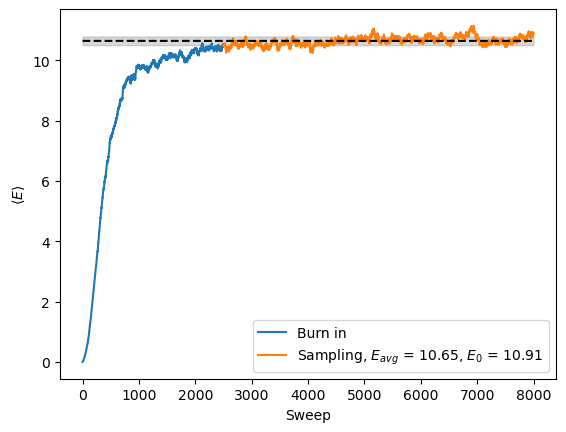

In [48]:
plt.plot(range(SWEEPS)[:BURNIN], E_sweeps[:BURNIN], label="Burn in")
plt.plot(range(SWEEPS)[BURNIN:], E_sweeps[BURNIN:], label=f"Sampling, $E_{{avg}}$ = {E_avg:.2f}, $E_0$ = {E_0:.2f}")
plt.plot(range(SWEEPS),E_avg * np.ones((SWEEPS)), "--", color="black")
plt.fill_between(range(SWEEPS), E_avg - E_std, E_avg + E_std, color="gray", alpha=0.3)
plt.xlabel("Sweep")
plt.ylabel(r"$\langle E \rangle$")
plt.legend()
plt.savefig("plots/energy_sweeps_8000_tau_5000_dtau_1.png")
plt.show()

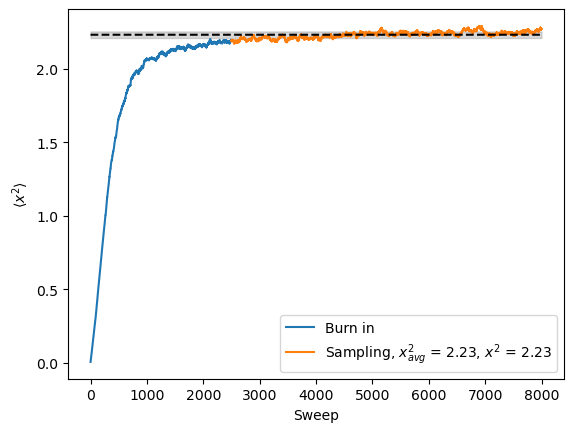

In [50]:
x2_avg = np.mean(x2_sweeps[BURNIN:])
x2_std = np.std(x2_sweeps[BURNIN:])

plt.plot(range(SWEEPS)[:BURNIN], x2_sweeps[:BURNIN], label="Burn in")
plt.plot(range(SWEEPS)[BURNIN:], x2_sweeps[BURNIN:], label=f"Sampling, $x^2_{{avg}}$ = {x2_avg:.2f}, $x^2$ = {x2_final:.2f}")
plt.plot(range(SWEEPS),x2_avg * np.ones((SWEEPS)), "--", color="black")
plt.fill_between(range(SWEEPS), x2_avg - x2_std, x2_avg + x2_std, color="gray", alpha=0.3)
plt.xlabel("Sweep")
plt.ylabel(r"$\langle x^2 \rangle$")
plt.legend()
plt.savefig("plots/x2_sweeps_8000_tau_5000_dtau_1.png")
plt.show()

## Problem B

In [51]:
import scipy
import scipy.linalg
import scipy.sparse.linalg

OMEGA = 1
BOXSIZE = 8
ND = 600
DELTAX = BOXSIZE / ND
HBAR = 1 
ALPHA = 0.4
XMIN = -4
XMAX = 4
EPS = np.pi / 128

x = np.linspace(-BOXSIZE / 2, BOXSIZE / 2, ND + 1)

def V(x):
    return ALPHA*x**4 - 2*x**2 + 1/ALPHA

H = np.zeros((ND + 1, ND + 1))

for i in range(ND + 1):
    for j in range(ND + 1):
        # kinetic part
        H[i, j] = -(0.5 / DELTAX**2) * ((i + 1 == j) - 2 * (i == j) + (i - 1 == j)) 
        # potential part
        H[i, j] += V(x[i]) * (i == j)

In [52]:
def power_method(H, sigma, n):
    Hms_inv = scipy.linalg.inv(H - sigma*np.eye(ND + 1))
    u = np.random.random(size=(ND + 1))
    lambda_u = np.dot(u.conjugate(), H @ u) / np.dot(u.conjugate(), u)
    for _ in range(n):
        u = Hms_inv @ u
        u /= np.sqrt(np.dot(u.conjugate(), u) * DELTAX)
        lambda_u = np.dot(u.conjugate(), H @ u) / np.dot(u.conjugate(), u)
    return u

phi_0_expected = power_method(H, 1.2, 100)

prob_0_expected = np.real(phi_0_expected * phi_0_expected.conjugate())

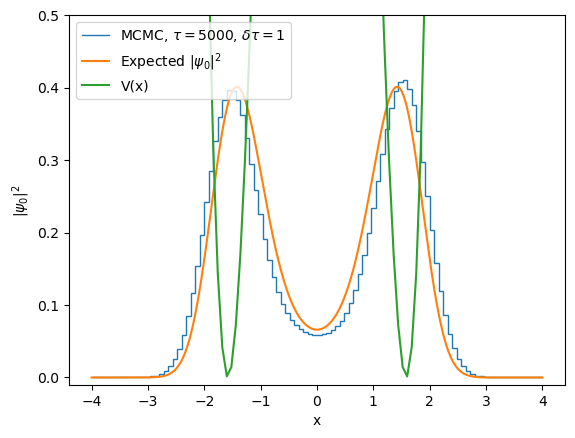

In [53]:
V_plot = V(x_bins)

DELTAX = (XHIGH - XLOW) / NXBINS
plt.figure()
plt.stairs(prob_histogram/np.sum(prob_histogram*DELTAX), x_bins, label=f"MCMC, $\\tau = {TAU}$, $\\delta\\tau={DELTATAU}$")
plt.plot(x, prob_0_expected, label="Expected $|\psi_0|^2$")
plt.plot(x_bins, V(x_bins), label="V(x)")
plt.ylim([-0.01, 0.5])
plt.xlabel("x")
plt.ylabel("$|\psi_0|^2$")
plt.legend()
plt.savefig("plots/pdf_comparison.png")
plt.show()

## Problem C

In [132]:
SWEEPS = 8000
H = 1
OMEGA = 1
M = 1
TAU = 5
DELTATAU = 1
NTAU = int(TAU/DELTATAU)
HITSIZE = 0.1
ALPHA = 0.4

XLOW = -4
XHIGH = 4
NXBINS = 100
DELTAX = (XHIGH - XLOW) / NXBINS
HITSIZE = 0.1
x_bins = np.linspace(XLOW, XHIGH, NXBINS + 1)
prob_histogram = np.zeros(NXBINS)
x_path = np.zeros(NTAU)

In [133]:
def V(x):
    return ALPHA*x**4 - 2*x**2 + 1/ALPHA

In [134]:
def vary_path(x_current):
    x_prime = x_current + np.random.random() * 2 * HITSIZE - HITSIZE
    while x_prime > XHIGH or x_prime < XLOW:
        x_prime = x_current + np.random.random() * 2 * HITSIZE - HITSIZE
    return x_prime

def action(x_left, x_right):
    K = 0.5 * M * (((x_right - x_left))**2) / DELTATAU
    V = DELTATAU * ( ALPHA * ((x_left + x_right)/2)**4 - 2*((x_left + x_right)/2)**2 + 1/ALPHA)
    return K + V

def total_action(x_path):
    path_action = 0
    for i in range(-1, NXBINS-1):
        path_action += action(x_path[i], x_path[i+1])
    return path_action

def delta_action(x_path, x_prime, i):
    x_left = x_path[i-1]
    x_right = x_path[i+1] if i < NTAU-1 else x_path[0] #PBC.
    daction = action(x_left, x_prime) + action(x_prime, x_right) 
    daction -= action(x_left, x_path[i]) + action(x_path[i], x_right) #compute the resulting change from u in delta S.
    return daction

def MCMC(x_path, prob_histogram):
    num_accept = 0
    E_values = []
    for i in range(NTAU):
        x_prime = vary_path(x_path[i])
        daction = delta_action(x_path, x_prime, i)
        if daction <= 0:            
            x_path[i] = x_prime
        else:        
            prob = np.exp(-daction)
            if np.random.random() < prob:
                x_path[i] = x_prime
                num_accept += 1
    hist, _ = np.histogram(x_path, bins=x_bins)
    return hist

In [135]:
def x2_exp(pdf, x):
    return sum(pdf * x**2 * DELTAX)

def x4_exp(pdf, x):
    return sum(pdf * x**4 * DELTAX)

def E_exp(pdf, x2, x4):
    return x2 + 3*(ALPHA)*x4

x_centers = (x_bins[:-1] + x_bins[1:]) / 2
x2_sweeps = []
x4_sweeps = []
E_sweeps = []

BURNIN = 2500

for k in tqdm.tqdm(range(SWEEPS)):
    hist = MCMC(x_path, prob_histogram)
    if k >= BURNIN:
        prob_histogram += hist
    pdf = hist/np.sum(hist*DELTAX)
    x2 = x2_exp(pdf, x_centers)
    x4 = x4_exp(pdf, x_centers)
    x2_sweeps.append(x2)
    x4_sweeps.append(x4) 
    E_sweeps.append(E_exp(pdf, x2, x4))

100%|██████████| 8000/8000 [00:00<00:00, 8616.77it/s]


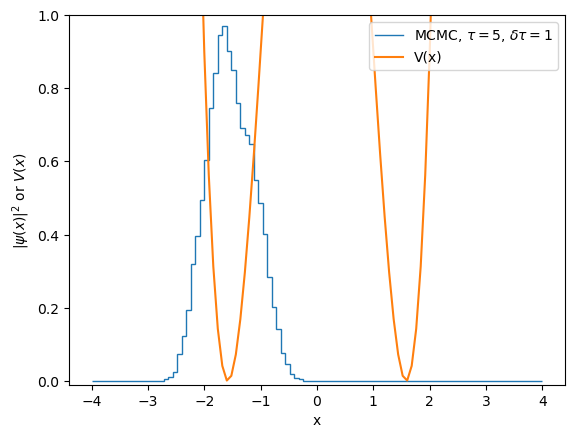

In [139]:
V_plot = V(x_bins)

plt.figure()
plt.stairs(prob_histogram/np.sum(prob_histogram*DELTAX), x_bins, label=f"MCMC, $\\tau = {TAU}$, $\\delta\\tau={DELTATAU}$")
plt.plot(x_bins, V(x_bins), label="V(x)")
plt.xlabel("x")
plt.ylabel("$|\psi(x)|^2$ or $V(x)$")
plt.ylim([-0.01, 1])
plt.legend()
plt.savefig(f"plots/sweeps_8000_tau_{TAU}_dtau_1.png")
plt.show()